In [ ]:
import pandas as pd
import mysql.connector
import os
from sqlalchemy import create_engine

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation'),# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='913743',
    database='ecommerce_dataset'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path ="D:/Desktop/Programming/data analytics/portfolio Project Using sql and python/database"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine

# Database connection details
host = "127.0.0.1"
user="root"
password="913743"
database="ecommerce_database"

# Create SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

# Directory containing CSV files
csv_directory = "D:/Desktop/Programming/data analytics/portfolio Project Using sql and python/database"

# Loop through all CSV files in the directory
for file in os.listdir(csv_directory):
    if file.endswith(".csv"):  # Process only CSV files
        file_path = os.path.join(csv_directory, file)
        
        # Read CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Convert filename into a table name (remove .csv extension)
        table_name = os.path.splitext(file)[0]
        
        # Upload data to MySQL
        df.to_sql(table_name, con=engine, if_exists="replace", index=False, chunksize=1000)
        
        print(f"✅ Successfully uploaded {file} to table {table_name}")

print("🎉 All files uploaded successfully!")


✅ Successfully uploaded customers.csv to table customers
✅ Successfully uploaded geolocation.csv to table geolocation
✅ Successfully uploaded orders.csv to table orders
✅ Successfully uploaded order_items.csv to table order_items
✅ Successfully uploaded payments.csv to table payments
✅ Successfully uploaded products.csv to table products
✅ Successfully uploaded sellers.csv to table sellers
🎉 All files uploaded successfully!


In [1]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as ptl
import seaborn as sns
from sqlalchemy import create_engine
import pymysql

conn = pymysql.connect(host= "127.0.0.1",
                               user= "root",
                               password= "913743",
                               database= "ecommerce_database")


cur = conn.cursor()

# List all unique cities where customers are located.

In [3]:
query = """ select distinct(customer_city) from customers"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data=cur.fetchall()
"Total order placed in 2017 are:" ,data[0][0]

('Total order placed in 2017 are:', 45101)

#  Find the total sales per category.

In [5]:
query = """ select `product category` ,count(*) as category_count from products where `product category`!= "" group by `product category` order by `product category` desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=("product category","category_count"))
df.head(10)

,product category,category_count
0,Watches present,1329
1,toys,1411
2,telephony,1134
3,technical books,123
4,stationary store,849
5,sport leisure,2867
6,song,27
7,SIGNALIZATION AND SAFETY,93
8,Room Furniture,156
9,pet Shop,719


# final solution of total sales per category

In [6]:
query = """select upper(products.`product category`)as category ,
round(sum(payments.payment_value),2) as total_sold_price
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df =pd.DataFrame(data,columns=["Category","Total_sold_price"])
df

,Category,Total_sold_price
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

# considering 1 as part of installments

In [7]:
query = """select sum(case when payment_installments >=1 then 1 else 0 end)/(count(*))*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data

((Decimal('99.9981'),),)

# not considering 1 as installments


In [8]:
query = """select 
sum((case when payment_installments >1 then 1 else 0 end))/(count(*))*100
from payments"""
cur.execute(query)
data=cur.fetchall()
data

((Decimal('49.4176'),),)

#  Count the number of customers from each state.

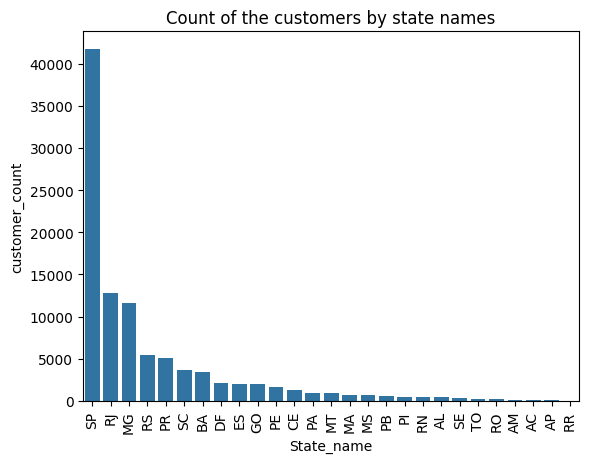

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
query = """select 
customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns=["State_name","customer_count"])
df=df.sort_values(by= "customer_count",ascending=False)
sns.barplot(x=df["State_name"],y=df["customer_count"],data=df)
plt.xticks(rotation=90)
plt.title("Count of the customers by state names")
plt.show()


# Calculate the number of orders per month in 2018.

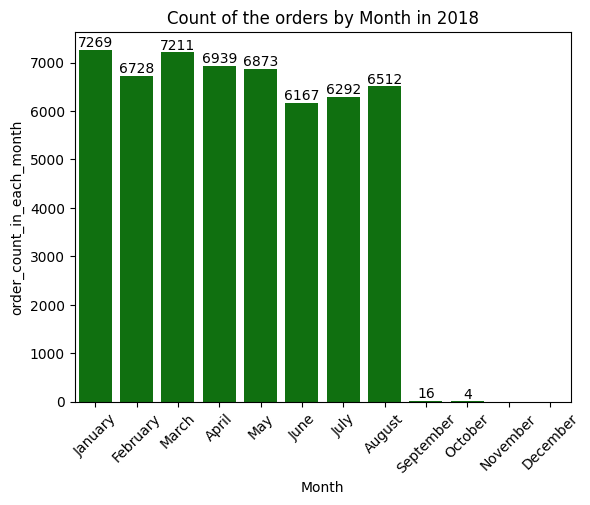

In [13]:
query = """select 
monthname(order_purchase_timestamp) as months,count(order_id) as order_count_in_month
from orders where year(order_purchase_timestamp)=2018 group by months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=("Month","order_count_in_each_month"))
o=['January','February','March','April','May','June','July','August','September','October','November','December']
ax=sns.barplot(data=df,x=df["Month"],y=df["order_count_in_each_month"],order=o,color="green")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title("Count of the orders by Month in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.


In [14]:
query = """with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city,round(avg(count_per_order.oc) ,2)as AverageProductsPerOrder
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by AverageProductsPerOrder desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=("customer_city","AverageProductsPerOrder"))
df.head(10)

,customer_city,AverageProductsPerOrder
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """select upper(products.`product category`)as category ,
round((sum(payments.payment_value)/(select sum(payment_value) from payments)*100),2) as Sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
order by Sales desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=("category","Sales_percentage"))
df


,category,Sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
import numpy as np
query = """select products.`product category` as category,count(order_items.product_id) as cnt,round(avg(order_items.price),2) as Avg_Price
from products join order_items
on order_items.product_id=products.product_id
group by category
order by cnt desc
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=("Category","Order_count","Avg_Price"))
arr1=df["Order_count"]
arr2=df["Avg_Price"]

a=np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is : ",a[0][1])
df

The correlation between product price and the number of times a product has been purchased is :  -0.10631514167157564


,Category,Order_count,Avg_Price
0,bed table bath,11115,93.30
1,HEALTH BEAUTY,9670,130.16
2,sport leisure,8641,114.34
3,Furniture Decoration,8334,87.56
4,computer accessories,7827,116.51
...,...,...,...
69,La Cuisine,14,146.78
70,cds music dvds,14,52.14
71,PC Gamer,9,171.77
72,Fashion Children's Clothing,8,71.23


# Calculate the total revenue generated by each seller, and rank them by revenue.

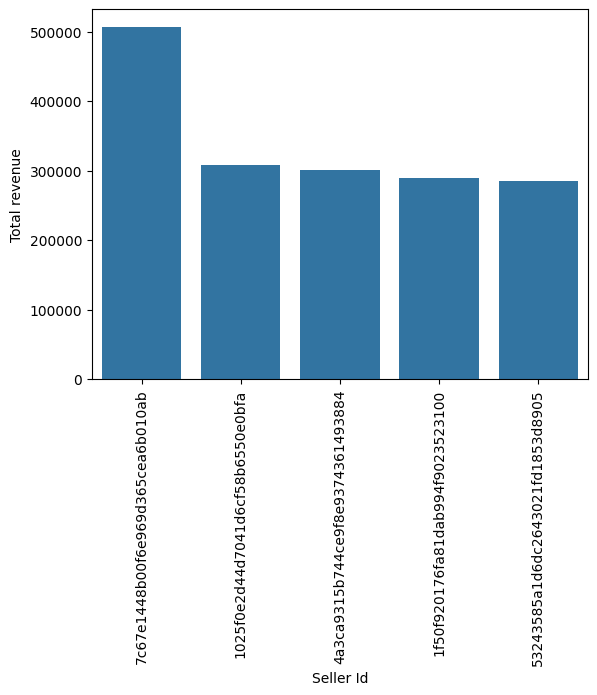

,Seller Id,Total revenue,Seller RAnk
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


In [16]:
query = """select * , dense_rank() over(order by revenue desc) as Seller_rank from
(select order_items.seller_id, round(sum(payments.payment_value),2) as revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller Id","Total revenue","Seller RAnk"])
df=df.head()
sns.barplot(data=df,x="Seller Id",y="Total revenue")
plt.xticks(rotation=90)
plt.show()
df

# Calculate the moving average of order values for each customer over their order history.

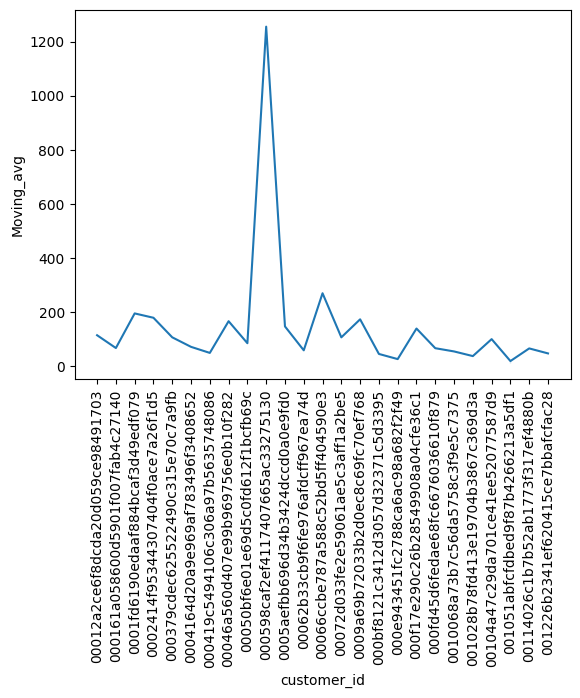

In [9]:
query = """select customer_id, order_purchase_timestamp,payment,avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg from 
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id) as a;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","Payment","Moving_avg"])
df=df.head(30)
sns.lineplot(data=df,x="customer_id",y="Moving_avg")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Calculate the cumulative sales per month for each year.

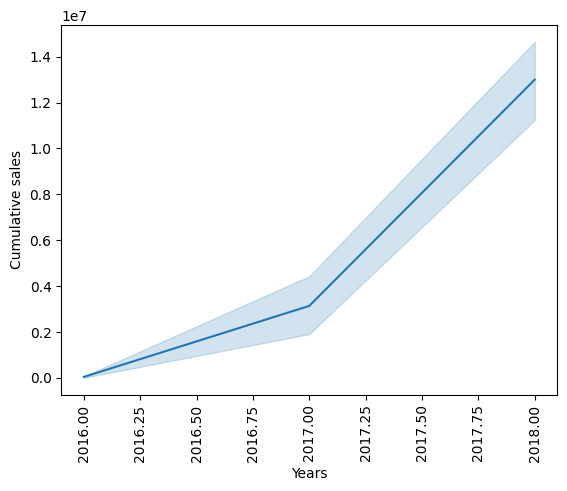

In [19]:
query = """select years,months , sales,sum(sales) over(order by years ,months) as cumulative_sales from 
(select month(orders.order_purchase_timestamp) as months,
year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as sales  
from 
orders join payments
on orders.order_id=payments.order_id
group by years , months order by years , months asc) as a;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Months","Sales","Cumulative sales"])
sns.lineplot(data=df,y="Cumulative sales",x="Years")
plt.xticks(rotation=90)
plt.show()

In [ ]:
 # Calculate the year-over-year growth rate of total sales.

   years  YOY_growth_rate
0   2016              NaN
1   2017          12112.7
2   2018             20.0


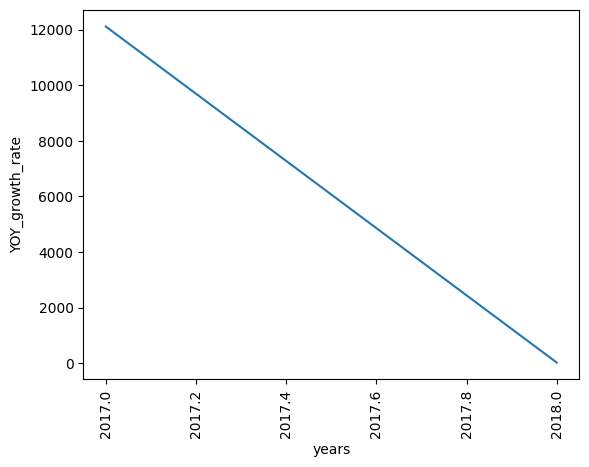

In [30]:
query = """with a as 
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value) ,2) as Sales_in_year
from orders join payments
on orders.order_id=payments.order_id
group by years
order by years)
select years ,round((Sales_in_year-(lag(Sales_in_year,1) over(order by years)))/(lag(Sales_in_year,1) over(order by years))*100,2) as YOY_growth_rate from a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","YOY_growth_rate"])
print(df)
sns.lineplot(data=df,x="years",y="YOY_growth_rate")
plt.xticks(rotation=90)
plt.show()

#  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [38]:
query = """with a as (
select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order_time
from orders join customers
on customers.customer_id=orders.customer_id
group by customers.customer_id),
b as 
(select a.customer_id , count(distinct orders.order_purchase_timestamp) 
from a join orders
on a.customer_id=orders.customer_id
and orders.order_purchase_timestamp>first_order_time
and orders.order_purchase_timestamp<=date_add(first_order_time , interval 6 month) 
group by a.customer_id)

select 100*(count(distinct a.customer_id))/(count(distinct b.customer_id)) as retention_rate
from a left join b
on a.customer_id=b.customer_id;

"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["retention_rate"])
df

,retention_rate
0,None


# Identify the top 3 customers who spent the most money in each year.

[]

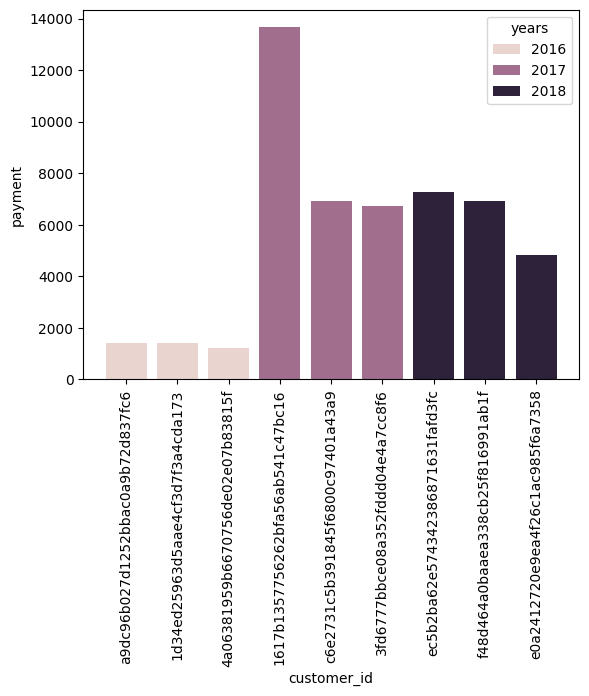

In [44]:
query = """select customer_id,years,payment,cx_rank
from 
(select orders.customer_id,
year(orders.order_purchase_timestamp) as years,
sum(payments.payment_value) as payment,
dense_rank() over( partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) as cx_rank
from orders join payments
on orders.order_id=payments.order_id
group by orders.customer_id,orders.order_purchase_timestamp) as a
where cx_rank <=3;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","years","payment","cx_rank"])
sns.barplot(x="customer_id",y="payment",data=df ,hue="years")
plt.xticks(rotation=90)
plt.plot()